# Machine Learning with TensorFlow

## Tensors

In [1]:
import tensorflow as tf
print(tf.version)
import tensorflow.compat.v2.feature_column
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import clear_output
from six.moves import urllib
from random import randrange

<module 'tensorflow._api.v2.version' from 'C:\\Users\\Mauri\\Repositories\\MachineLearning\\env\\lib\\site-packages\\tensorflow\\_api\\v2\\version\\__init__.py'>


### Tensor rank and shape

Tensors can have rank 0-n (basically refers to the dimensions). <br>
Tensors' shape is the amount of elements/data in the tensors. <br>
* Shapes can be reshaped.

In [2]:
#Declare and initialize tensors
rank0_tensor = tf.Variable(9, tf.int16)
rank1_tensor = tf.Variable([1,2,3], tf.float64)
rank2_tensor = tf.Variable([[1,2,3], [4,5,6]], tf.int16)
rank3_tensor = tf.Variable([[[1,2,3],[4,5,6]],[[7,8,9],[10,11,12]]])

In [3]:
#Get rank of tensor
tf.rank(rank1_tensor)

#Get shape of tensor
rank1_tensor.shape
rank2_tensor.shape
rank3_tensor.shape

TensorShape([2, 2, 3])

In [4]:
#Reshape tensors

#Will create tensor with given shape with all 1
#tf.zeros also exits
oneTensor = tf.ones([2,3])
#print(oneTensor)

#Reshape
#-1 lets TensorFlow infer the dimension for that value
oneTensor = tf.reshape(oneTensor, [6])
print(oneTensor)
tf.rank(oneTensor)

tf.Tensor([1. 1. 1. 1. 1. 1.], shape=(6,), dtype=float32)


<tf.Tensor: shape=(), dtype=int32, numpy=1>

### Tensor types
All tensor type are immutable except for "Variable". Availabe tensor types are: <br>
* Variable
* Constant
* Placeholder
* SparseTensor

### Evaluating tensors
Create session. <br>
The code evaluates the tensor variable that is stored in the default graph. The default graph holds all operations not specified to another graph. It is possible to create own seperate graphs.

In [5]:
#with tf.Session() as session: #this uses the default graph
    # oneTensor.eval() #tensor to evaluate

## TensorFlow's Core Learning Algorithms

### Linear Regression
Creates a line of best fit through a scatter plot of data
points that best expresses the relationship between those points. <br>
This can be done in any kind of dimensions. <br>

Feature columns are columns that contain the unique data, either categorical or numerical, per column of input data.

Epochs are the times the model re-evaluates data and thus learns from it.

Overfitting occurs when the same data is feed to the model too much, data is almost memorized which degrades future predictions.

Batches are used to feed smaller amounts to the model.

Data from: https://www.kaggle.com/uciml/pima-indians-diabetes-database

In [6]:
#Load data
dfTrain = pd.read_csv('CSV_Data/diabetes_train.csv')
dfTrain.pop('SkinThickness')
dfTrain.pop('Insulin')
dfEvaluate = pd.read_csv('CSV_Data/diabetes_eval.csv')
dfEvaluate.pop('SkinThickness')
dfEvaluate.pop('Insulin')
y_train = dfTrain.pop('Outcome')
y_evaluate = dfEvaluate.pop('Outcome')

#Just list
#y_train.head()
dfTrain.head()

#Statistical
#dfTrain.describe()

#dfTrain.shape

,Pregnancies,Glucose,BloodPressure,BMI,DiabetesPedigreeFunction,Age
0,6,148,72,33.6,0.627,50
1,1,85,66,26.6,0.351,31
2,8,183,64,23.3,0.672,32
3,1,89,66,28.1,0.167,21
4,0,137,40,43.1,2.288,33


Visuals can also be created.

<AxesSubplot:>

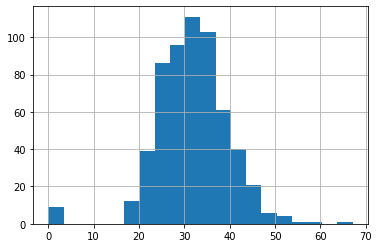

In [7]:
dfTrain.BMI.hist(bins=20)

<AxesSubplot:>

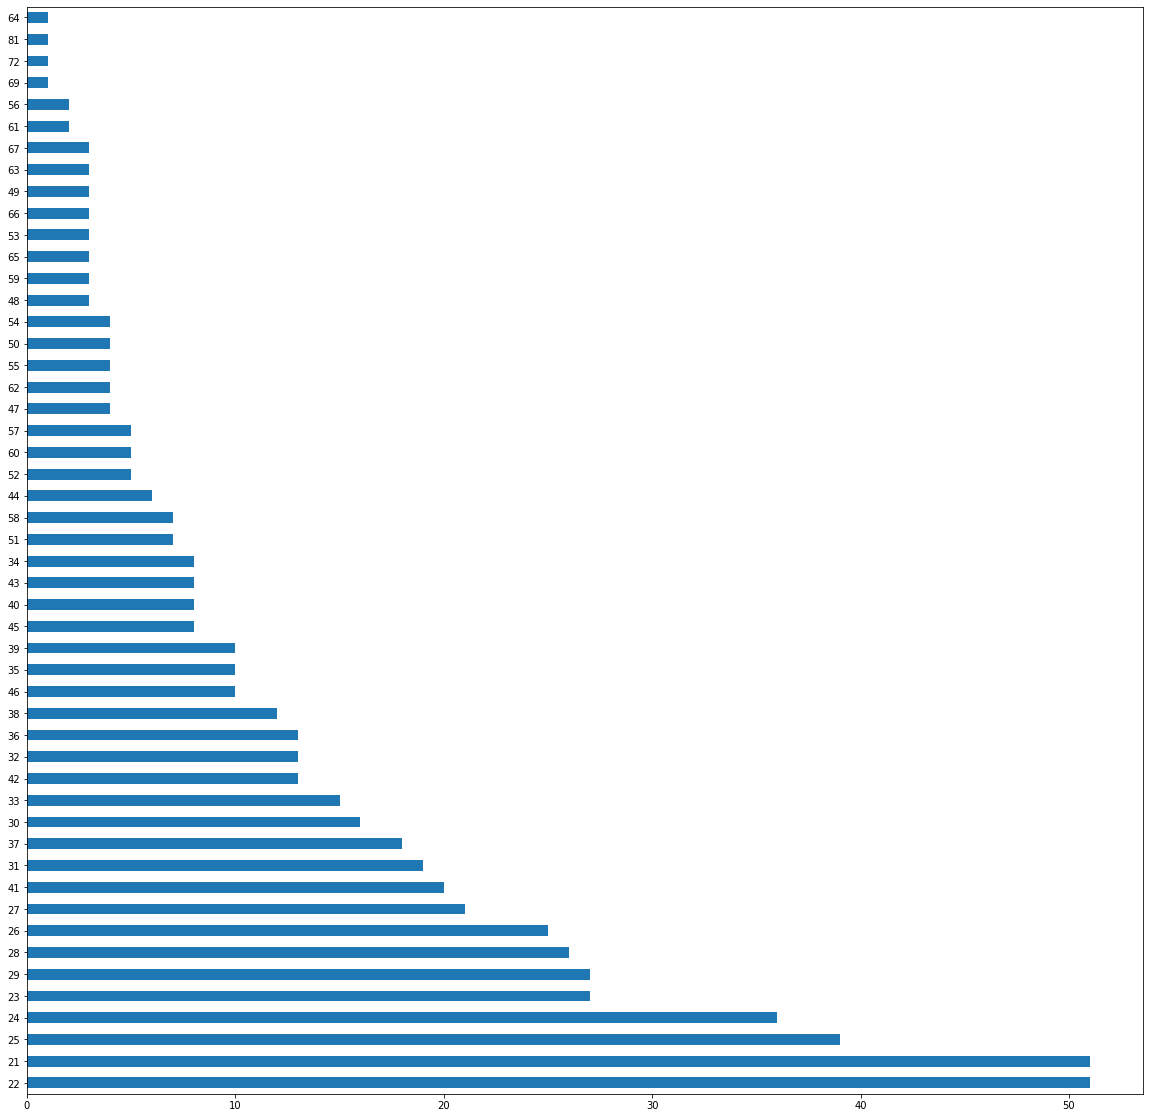

In [8]:
dfTrain.Age.value_counts().plot(kind='barh', figsize=(20,20))

Text(0.5, 0, '% high blood pressure')

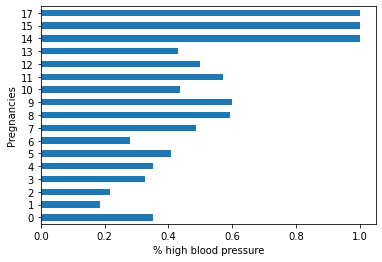

In [9]:
pd.concat([dfTrain, y_train], axis=1).groupby('Pregnancies').Outcome.mean().plot(kind='barh').set_xlabel('% high blood pressure')

Input functions are special functions that describe how data is fed into the model during the training process e.g. epochs, batch size etc.

The tensor flow model expects data to be a "tf.data.Dataset" object.

In [130]:
def CreateInputFunction(dataDataFrame, labelDataFrame, numEpochs=27, shuffle=True, batchSize=32):
    def InputFunction():
        #tf.data.Dataset object creation
        dataSet = tf.data.Dataset.from_tensor_slices((dict(dataDataFrame), labelDataFrame))
        if shuffle:
            dataSet = dataSet.shuffle(1000)
        dataSet = dataSet.batch(batchSize).repeat(numEpochs)
        return dataSet
    return InputFunction

trainInputFunction = CreateInputFunction(dfTrain, y_train)
evaluationInputFunction = CreateInputFunction(dfEvaluate, y_evaluate)


In [131]:
#Create feature columns
for col in dfTrain.columns:
    print(col)
    
featureColumns = []
for col in dfTrain.columns:
    featureColumns.append(tf.feature_column.numeric_column(col, dtype=tf.float32))

Pregnancies
Glucose
BloodPressure
BMI
DiabetesPedigreeFunction
Age


In [132]:
#Model creation
linearEstimator = tf.estimator.LinearClassifier(feature_columns=featureColumns)

#Model training
linearEstimator.train(trainInputFunction)
result = linearEstimator.evaluate(evaluationInputFunction)

clear_output()
print(result['accuracy'])

0.66101694


In [163]:
# Use model to make predictions
predictDictionaries = list(linearEstimator.predict(evaluationInputFunction))
index = randrange(177);
print(dfEvaluate.loc[index])
print(y_evaluate.loc[index])
print(predictDictionaries[index]['probabilities'])

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\Mauri\AppData\Local\Temp\tmp52gs4ekq\model.ckpt-513
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Pregnancies                   1.000
Glucose                     121.000
BloodPressure                78.000
BMI                          39.000
DiabetesPedigreeFunction      0.261
Age                          28.000
Name: 160, dtype: float64
0
[0.65579885 0.34420115]


### Classification

### Clustering

### Hidden Markov Models